# Natural Language Processing with Deep Learning

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

We can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [3]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# !curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
# !tar -xvzf ./Train_rev1.csv.tar.gz

In [7]:
data = pd.read_csv("drive/MyDrive/dl_hw4/Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
222843,72397014,"Technical Design Authority, to ****K, benefits",TDA sought to join this impressive global soft...,Buckinghamshire - Milton Keynes,Milton Keynes,full_time,permanent,UKStaffsearch,HR & Recruitment Jobs,55000 - 57000,56000,ukstaffsearch.com,10.933125
1150,46636002,ODP/Scrub Recovery Nurse,ODP/Scrub & Recovery Nurse Surrey Full Time **...,"Caterham, Surrey",Caterham,full_time,NaN,NaN,Healthcare & Nursing Jobs,30000 to 32000 per year,31000,careworx.co.uk,10.341775
61273,68695726,Business Development Manager,Our client who is a market leader in the logis...,Coventry West Midlands (County) West Midlands,UK,NaN,permanent,Networx.,Sales Jobs,"50,000 - 60,000 Basic + Car allowance",55000,totaljobs.com,10.915107


## Classic NLP approach (70%)

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [9]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [11]:
data["Title"][:100]

0                           engineering systems analyst
1                               stress engineer glasgow
2                      modelling and simulation analyst
3     engineering systems analyst / mathematical mod...
4           pioneer , miser engineering systems analyst
                            ...                        
95    chef de parties required nationwide many with ...
96       chef de partie norfolk live in up to **** tips
97                      plastic extrusion setter nights
98    assistant manager suffolk coastal restaurant ****
99                              cluster revenue manager
Name: Title, Length: 100, dtype: object

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [12]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
  data[col].apply(lambda x:  token_counts.update(x.split()))

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

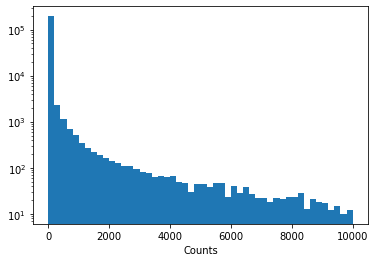

In [14]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [17]:
token_to_id = dict((token, i) for i, token in enumerate(tokens))

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary we've built to map text lines into torch-digestible matrices.

In [19]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [23]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[ 3162,  1314,  1464,   561,   304,  2526,     9,  3939,   282,
           706],
        [ 5831,  5320,  2319,   558,   559,   944,    73,  1029,  1704,
            86],
        [12842,  1055, 11462,  1732,  2401,    55,   416,    34,   312,
           246]], dtype=int32),
 'Log1pSalary': array([ 9.670357,  9.488048, 10.134639], dtype=float32),
 'Title': array([[2378,   11, 2310],
        [1029,  531,    1],
        [ 246, 1732,  247]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [25]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [26]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.functional.relu(h)
        h = self.dense(h)
        
        return h

In [27]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [28]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.functional.relu(h)
        h = self.dense(h)
        
        return h

In [29]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [29]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size = 64)
        
        self.categ_dense1 = nn.Linear(n_cat_features, 64)
        self.categ_dense2 = nn.Linear(64, 128)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense1 = nn.Linear(256, 256)
        self.dense2 = nn.Linear(256, 64)
        self.dense3 = nn.Linear(64, 1)
        
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_dense1(cat_features)
        cat_h = nn.functional.relu(cat_h)
        cat_h = self.categ_dense2(cat_h)
        cat_h = nn.functional.relu(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense1(joint_h)
        joint_h = nn.functional.relu(joint_h)
        joint_h = self.dense2(joint_h)
        joint_h = nn.functional.relu(joint_h)
        joint_h = self.dense3(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [30]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [30]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [33]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [42]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [35]:
num_epochs = 50
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [36]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        print(prediction[:3])
        print(reference[:3])
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


tensor([-0.0985, -0.0935, -0.0825], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 11.0822, 10.4631], device='cuda:0')
tensor([0.0803, 0.0997, 0.0719], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.7790, 10.5119], device='cuda:0')
tensor([0.2317, 0.2980, 0.2435], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.9596, 10.4564], device='cuda:0')
tensor([0.4592, 0.4320, 0.4178], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.4341, 10.8198], device='cuda:0')
tensor([0.6285, 0.6698, 0.7402], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.1216, 10.3090], device='cuda:0')
tensor([0.7687, 0.9315, 1.1103], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.3735,  9.3057], device='cuda:0')
tensor([1.3620, 1.2095, 1.5462], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0450, 10.8198, 10.5967], device='cuda:0')
tensor([1.4974, 1.4668, 1.9172], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6704,  9.9523, 


	Loss:	0.55445
	MAE:	7040.67922



Training:


tensor([ 9.4056, 10.8102, 11.6070], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9580, 10.8198, 10.4043], device='cuda:0')
tensor([ 9.7914,  9.8042, 10.4484], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.6335, 10.7033], device='cuda:0')
tensor([10.0815, 10.1499, 10.7386], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3578, 11.3504, 10.2036], device='cuda:0')
tensor([10.6009, 11.0595,  9.1833], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3090, 11.0822, 10.1943], device='cuda:0')
tensor([10.0933, 11.1754, 10.1959], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4464, 10.9596, 10.2220], device='cuda:0')
tensor([ 8.9382, 11.0640, 10.6347], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5238, 11.1331, 10.9151], device='cuda:0')
tensor([11.1182,  9.8959, 10.1318], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.2220, 10.5321], device='cuda:0')
tensor([ 9.7922,  9.6368, 10.4024], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.36314
	MAE:	5908.36770



Training:


tensor([ 9.6632, 10.0932, 11.0292], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3578,  9.7410, 10.3890], device='cuda:0')
tensor([10.3507, 10.0651,  9.8957], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.7112, 9.8716, 9.6959], device='cuda:0')
tensor([ 9.6591, 10.8669, 10.8436], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 10.2751, 10.2220], device='cuda:0')
tensor([ 9.7805, 10.5442,  9.9212], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0433, 10.6573,  9.6804], device='cuda:0')
tensor([ 7.7107,  9.8854, 10.2014], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.1696, 9.9988, 9.7982], device='cuda:0')
tensor([ 9.6788, 10.3896,  9.7627], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.2220, 10.4341], device='cuda:0')
tensor([ 9.5428, 10.4260,  9.8096], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2682, 10.2239, 10.4913], device='cuda:0')
tensor([10.5822,  9.8849, 10.1529], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.


	Loss:	0.33223
	MAE:	4796.80041



Training:


tensor([10.1047, 10.0054, 10.2399], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631, 10.1267, 10.1024], device='cuda:0')
tensor([10.5711,  9.4176, 10.0766], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.8297, 11.0021], device='cuda:0')
tensor([ 9.3407, 10.8689,  9.1451], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4697, 10.5321,  9.6557], device='cuda:0')
tensor([ 9.7019, 10.2823,  9.5889], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0413, 10.0859, 10.0213], device='cuda:0')
tensor([10.5804,  9.8061,  9.9876], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5305, 10.2577, 10.6805], device='cuda:0')
tensor([ 9.6213, 10.0423, 11.5321], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5558,  9.7292, 10.9151], device='cuda:0')
tensor([11.1929, 10.0872, 10.3681], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859,  9.6159, 10.2220], device='cuda:0')
tensor([10.2637,  9.9922,  9.8956], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.26336
	MAE:	4882.89321



Training:


tensor([10.3865, 10.5373,  9.6738], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.6396, 9.9523, 9.5831], device='cuda:0')
tensor([10.1338, 10.3302, 10.2779], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6078, 10.2220, 10.1628], device='cuda:0')
tensor([10.4954, 10.0290,  9.5022], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321,  9.9988, 10.3042], device='cuda:0')
tensor([10.4050, 10.2243, 10.1247], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.5750,  9.3830], device='cuda:0')
tensor([11.1158, 10.5308,  9.2456], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9151, 10.5967,  9.1370], device='cuda:0')
tensor([11.0541,  9.3193, 10.4254], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822,  9.9988, 10.5324], device='cuda:0')
tensor([10.3270, 10.7395, 10.5869], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198,  9.9035, 10.3090], device='cuda:0')
tensor([10.2803,  9.6317, 10.3150], device='cuda:0', grad_fn=<SliceBackward>)
tensor([


	Loss:	0.26933
	MAE:	5434.70553



Training:


tensor([10.7093, 10.6338, 10.1460], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.3890,  9.9035], device='cuda:0')
tensor([10.4578, 10.8089, 10.2635], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890, 10.5321, 10.2220], device='cuda:0')
tensor([10.7568,  9.4024, 10.9696], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890,  9.8256, 10.7685], device='cuda:0')
tensor([10.3706, 10.9209, 10.0916], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7574, 10.8198, 10.5187], device='cuda:0')
tensor([ 9.7004, 10.6448, 10.2183], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9035, 11.3504, 11.3504], device='cuda:0')
tensor([10.2199, 10.4798, 10.7807], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1597, 10.7685, 10.2648], device='cuda:0')
tensor([ 9.6764, 10.2495, 10.0540], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4807, 10.1065, 11.1154], device='cuda:0')
tensor([10.3727,  9.8025, 10.0076], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.22730
	MAE:	4771.30346



Training:


tensor([10.1054, 10.3228, 10.3789], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3090, 10.0859, 10.4631], device='cuda:0')
tensor([10.9924, 11.0573, 10.8294], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4193, 11.4616, 11.0413], device='cuda:0')
tensor([10.4269, 10.4000, 10.3962], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2898, 10.9151, 10.3090], device='cuda:0')
tensor([10.8830, 10.7993, 10.6933], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.8198,  9.8522], device='cuda:0')
tensor([ 9.9656, 10.4988,  9.8817], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859, 10.4982, 11.3504], device='cuda:0')
tensor([10.1883,  8.6399, 10.7661], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0642,  9.3991, 10.5967], device='cuda:0')
tensor([10.5943,  9.4942, 11.1329], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144,  9.5412, 11.3794], device='cuda:0')
tensor([10.7379,  9.9977, 10.3263], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.20668
	MAE:	4065.80338



Training:


tensor([10.6693, 10.6416, 10.9249], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090, 11.4616], device='cuda:0')
tensor([10.7632, 10.4953, 10.5115], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 10.1267, 10.0213], device='cuda:0')
tensor([10.3926, 10.7370, 10.7797], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1465, 10.9596, 10.7685], device='cuda:0')
tensor([10.8738, 10.4786, 10.8018], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0021, 10.8278, 10.9151], device='cuda:0')
tensor([10.3342, 10.4680,  9.7135], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6573, 10.3735,  9.9523], device='cuda:0')
tensor([11.4899, 10.0323, 10.4626], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822,  9.7982, 10.1267], device='cuda:0')
tensor([10.5381,  9.4929,  9.3770], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.3482,  9.3830], device='cuda:0')
tensor([10.1264, 10.3542, 10.5357], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.23808
	MAE:	5329.76511



Training:


tensor([10.0784, 10.6993, 10.1890], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5667, 10.3890,  9.8522], device='cuda:0')
tensor([10.1294, 10.3015, 10.2187], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5187, 10.2577, 10.1267], device='cuda:0')
tensor([10.6754,  9.9206, 10.7145], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6573, 10.1267, 10.9151], device='cuda:0')
tensor([ 9.5210, 10.6691, 10.1081], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2922, 10.6736, 10.2220], device='cuda:0')
tensor([9.9817, 9.9689, 8.9446], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4193, 10.2922,  9.9580], device='cuda:0')
tensor([ 9.3446, 10.1327,  9.8595], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1065, 10.3090, 10.1876], device='cuda:0')
tensor([10.7996, 10.1237, 10.0179], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7364,  9.7700, 10.2220], device='cuda:0')
tensor([11.0480, 10.9294, 10.4650], device='cuda:0', grad_fn=<SliceBackward>)
tensor([


	Loss:	0.20225
	MAE:	4681.11080



Training:


tensor([11.1273, 10.6469, 10.6730], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1563, 10.4193, 10.9151], device='cuda:0')
tensor([10.6415, 10.8879, 10.5558], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8627, 10.4631, 10.2400], device='cuda:0')
tensor([10.8859, 10.5522, 10.5487], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7700, 11.1563, 10.6573], device='cuda:0')
tensor([10.9410, 11.3488, 10.2224], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.8198, 10.4913], device='cuda:0')
tensor([ 9.7497, 10.2767, 10.3965], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.5241,  9.9988], device='cuda:0')
tensor([10.0530, 10.0043,  9.8566], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1849,  9.5368, 10.8198], device='cuda:0')
tensor([10.2153, 10.2675,  9.9605], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9282,  9.9282, 10.0213], device='cuda:0')
tensor([10.0714,  9.6972, 10.8641], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.18963
	MAE:	3838.35503



Training:


tensor([10.8922, 10.4289, 11.1047], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.2577, 11.3386], device='cuda:0')
tensor([ 9.5203, 11.0158,  9.9206], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7002, 10.7144,  9.6804], device='cuda:0')
tensor([10.9373, 11.1469,  9.7480], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6573, 10.6573,  9.4728], device='cuda:0')
tensor([10.5042, 10.4430, 10.6007], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822, 10.0213, 10.0450], device='cuda:0')
tensor([10.1816, 10.9730, 10.4278], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6804, 10.3578, 10.5321], device='cuda:0')
tensor([9.5911, 9.1735, 9.9571], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.6159, 9.9282, 9.5751], device='cuda:0')
tensor([10.1198, 10.5402, 10.7661], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4773, 11.2594, 11.0822], device='cuda:0')
tensor([10.0298,  9.0622, 10.1235], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.


	Loss:	0.17050
	MAE:	3709.70314



Training:


tensor([ 9.9576, 10.3189, 10.9789], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2036, 10.7790, 11.2253], device='cuda:0')
tensor([10.5922, 10.4382,  9.1902], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.7277, 11.0021], device='cuda:0')
tensor([10.6395,  9.4577, 10.1784], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8782, 10.4631, 10.3090], device='cuda:0')
tensor([10.7499, 10.6245, 10.7704], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6736, 10.2220, 10.7685], device='cuda:0')
tensor([10.3710, 10.7829, 10.4054], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.3418, 10.5713], device='cuda:0')
tensor([11.3903, 10.6317,  9.6881], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2898, 10.5967,  9.5646], device='cuda:0')
tensor([ 9.5858, 10.3392, 10.5972], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.3266,  9.9035, 10.4631], device='cuda:0')
tensor([10.0317, 10.6818, 10.2052], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.15042
	MAE:	3700.80974



Training:


tensor([10.2978, 10.7302, 10.7460], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2036, 10.7144, 10.5967], device='cuda:0')
tensor([11.2509, 10.2535,  9.3878], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.2682,  9.5061], device='cuda:0')
tensor([10.2122, 10.9474, 11.1362], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 10.7685, 10.9151], device='cuda:0')
tensor([10.8118, 10.2956, 10.3719], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4043, 10.0648, 10.1659], device='cuda:0')
tensor([9.9132, 8.8173, 9.1120], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.9282, 9.6804, 9.5751], device='cuda:0')
tensor([ 9.2443, 10.1052, 10.2674], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9523, 10.1267, 10.1849], device='cuda:0')
tensor([ 9.8540,  9.7308, 10.5829], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4728,  9.9642, 10.9613], device='cuda:0')
tensor([ 8.9346, 10.0603, 11.5439], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.


	Loss:	0.14464
	MAE:	3574.49189



Training:


tensor([10.5587, 10.6665, 10.3243], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.8198, 10.2220], device='cuda:0')
tensor([10.3940, 10.3569, 10.4238], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2898,  9.5061, 10.5967], device='cuda:0')
tensor([10.3180, 10.6777,  9.6054], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.6624,  9.5902], device='cuda:0')
tensor([10.1083, 10.3994, 11.0541], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7410, 10.6573, 10.5967], device='cuda:0')
tensor([11.7282, 10.5227, 10.1041], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.3794, 10.3090,  9.8980], device='cuda:0')
tensor([10.6552, 10.1375, 10.2616], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1844, 10.4779,  9.9988], device='cuda:0')
tensor([11.1108, 10.3734, 10.0559], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9596, 10.7685, 10.2751], device='cuda:0')
tensor([10.3023,  9.7662,  9.6673], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.15251
	MAE:	3901.50716



Training:


tensor([11.2253, 10.5872, 10.4268], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2709, 10.3578, 10.5051], device='cuda:0')
tensor([10.2102, 10.3865,  9.4735], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220, 10.1943,  9.5751], device='cuda:0')
tensor([10.8451,  9.4612, 10.4692], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1419,  9.5751, 10.6920], device='cuda:0')
tensor([10.6925,  9.8797, 10.8333], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4773,  9.6804, 10.8317], device='cuda:0')
tensor([10.9024,  9.8892,  9.4087], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967,  9.7700,  9.5820], device='cuda:0')
tensor([10.3378,  9.1291,  9.2867], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6324, 10.2577,  9.6487], device='cuda:0')
tensor([11.0274, 10.7482, 10.0806], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0021, 10.4631,  9.6078], device='cuda:0')
tensor([ 9.5711,  9.6160, 10.1944], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.13896
	MAE:	3623.83863



Training:


tensor([10.7274, 10.3026, 10.2851], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198,  9.3927, 10.4913], device='cuda:0')
tensor([10.6077, 11.0580, 10.0308], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822, 10.9151, 10.1849], device='cuda:0')
tensor([10.0442, 10.4503, 10.3732], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6520, 10.2400, 10.3735], device='cuda:0')
tensor([11.4239, 10.2820,  9.8873], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.5321, 10.3090], device='cuda:0')
tensor([10.6982, 10.4129, 10.2908], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4341, 10.5321, 10.4631], device='cuda:0')
tensor([10.5246, 10.8890, 10.1965], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1877, 11.4076, 10.5967], device='cuda:0')
tensor([10.4768,  9.9979,  9.9097], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5713, 10.1849,  9.8522], device='cuda:0')
tensor([10.8251, 10.0707, 10.5987], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.14894
	MAE:	3515.84769



Training:


tensor([10.9120, 10.7650,  9.9287], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.4876, 10.8198,  9.7410], device='cuda:0')
tensor([10.4681, 10.1663, 10.6675], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2320,  9.9282, 10.6511], device='cuda:0')
tensor([10.4492, 10.6761,  9.7397], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1465, 10.5967,  9.6804], device='cuda:0')
tensor([10.2422, 10.9635,  9.6658], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.6573,  9.3935], device='cuda:0')
tensor([10.5610, 11.1325, 10.0172], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 11.2253, 10.0859], device='cuda:0')
tensor([ 9.8822,  9.2390, 10.1536], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859,  9.4728, 10.0213], device='cuda:0')
tensor([10.7724, 10.0894, 10.7771], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.3890, 10.9596], device='cuda:0')
tensor([10.4647, 11.1974, 10.8348], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.13100
	MAE:	3435.60040



Training:


tensor([10.3319,  9.7934, 10.9385], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890,  9.7410, 10.3090], device='cuda:0')
tensor([ 9.7784, 10.8775, 10.4289], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5751, 10.4341,  9.9580], device='cuda:0')
tensor([10.2627,  9.7563,  9.7914], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267,  9.5469,  9.7700], device='cuda:0')
tensor([10.8148, 10.5065, 10.0932], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5584, 11.5129, 10.2220], device='cuda:0')
tensor([10.0685, 10.5721, 10.0535], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2400, 10.2220,  9.7410], device='cuda:0')
tensor([10.6017,  9.9913, 10.6864], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4223, 10.3090, 10.5967], device='cuda:0')
tensor([ 9.4002, 10.4122, 10.2709], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.4287, 10.3090], device='cuda:0')
tensor([10.3484, 10.2676, 10.5727], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.15343
	MAE:	3570.66172



Training:


tensor([ 9.7996, 10.0733, 10.2878], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0656, 10.5967, 10.5051], device='cuda:0')
tensor([ 9.6145, 10.0196,  9.5708], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6159, 10.3418,  9.4078], device='cuda:0')
tensor([10.9793, 10.5019, 10.7567], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.5454, 10.7144], device='cuda:0')
tensor([10.9784, 10.3818,  9.4354], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890, 10.5584,  9.4510], device='cuda:0')
tensor([10.3186,  9.4077, 10.8735], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.3735, 10.8198], device='cuda:0')
tensor([10.5213, 11.5431, 10.2893], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859, 10.9596,  9.9035], device='cuda:0')
tensor([10.2963,  9.8583, 10.5574], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822,  9.9035, 10.5321], device='cuda:0')
tensor([10.2061, 10.0046, 10.4464], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.17704
	MAE:	4576.36454



Training:


tensor([11.4290, 10.8355, 10.8104], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2253, 10.7144, 10.4913], device='cuda:0')
tensor([10.6664, 10.4653, 10.3783], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 10.1024, 10.0859], device='cuda:0')
tensor([10.0464,  9.9307, 10.1727], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7004,  9.8627, 10.3578], device='cuda:0')
tensor([ 9.9345,  9.8413, 10.7011], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3418, 10.5321, 10.7144], device='cuda:0')
tensor([10.4037, 10.5122, 10.3246], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3090, 10.3890, 10.7144], device='cuda:0')
tensor([10.7803, 10.1445, 10.5368], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.7144, 10.1849], device='cuda:0')
tensor([10.5545, 10.6977, 10.4875], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220, 11.1563, 10.5967], device='cuda:0')
tensor([10.1004, 10.8624, 10.3768], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.15588
	MAE:	4156.46300



Training:


tensor([11.2156,  9.8807, 11.3975], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.4721,  9.6944, 11.0035], device='cuda:0')
tensor([10.1179, 10.9901, 11.1296], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.6046, 10.5967], device='cuda:0')
tensor([11.0329, 10.7219, 10.1994], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0760, 10.3890,  9.7410], device='cuda:0')
tensor([10.3252, 10.6705,  9.8522], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2400, 10.3418, 10.8198], device='cuda:0')
tensor([11.1263,  9.9051,  9.3748], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2898, 10.0859,  9.5105], device='cuda:0')
tensor([10.3901, 10.0360, 11.3527], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3418, 10.5321, 11.0429], device='cuda:0')
tensor([10.0034, 10.7852, 10.8254], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321,  9.9281, 10.9596], device='cuda:0')
tensor([10.5656, 10.3664, 10.5928], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11690
	MAE:	3262.50983



Training:


tensor([10.3619, 10.2612, 10.8981], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.2220, 10.3090], device='cuda:0')
tensor([10.0727, 10.0019, 10.0560], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220,  9.9282, 10.4043], device='cuda:0')
tensor([10.4902, 10.4575, 10.1806], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1914, 11.0822, 10.4631], device='cuda:0')
tensor([10.3576, 10.8878, 10.0895], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4779, 11.1914, 10.1267], device='cuda:0')
tensor([ 9.9618, 10.7270, 11.0436], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2969, 10.5321, 10.8686], device='cuda:0')
tensor([10.1345, 10.4513, 10.4743], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.1465, 10.3735], device='cuda:0')
tensor([ 9.4706, 10.4120, 10.3663], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9988, 10.0213, 10.3090], device='cuda:0')
tensor([ 9.1374, 10.8987, 10.8179], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11591
	MAE:	3232.16511



Training:


tensor([10.6330, 10.9542, 10.2349], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9151, 11.0429, 10.5187], device='cuda:0')
tensor([10.0781, 10.3047, 10.4753], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5061, 10.0450, 10.8686], device='cuda:0')
tensor([11.5365, 11.1149,  9.9920], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8875, 11.0021, 10.1267], device='cuda:0')
tensor([10.0289, 10.2305,  9.4748], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 10.1267,  9.7982], device='cuda:0')
tensor([ 9.9494, 10.0308,  9.7692], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.5454, 10.3090], device='cuda:0')
tensor([10.0679, 10.5889,  9.4057], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.9331, 10.0213], device='cuda:0')
tensor([10.0572, 10.6064, 10.5115], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213, 10.2751, 10.0558], device='cuda:0')
tensor([10.5292, 10.7985, 10.2913], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.14727
	MAE:	3960.11353



Training:


tensor([10.6402,  9.9500, 10.1147], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321,  9.9350, 10.3504], device='cuda:0')
tensor([10.7873, 10.5985, 10.1798], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.3554, 10.4631], device='cuda:0')
tensor([10.2545,  9.5956, 10.1817], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685,  9.6495, 11.2898], device='cuda:0')
tensor([10.2093, 10.5523, 10.5389], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.8198, 10.7144], device='cuda:0')
tensor([10.0862, 10.8432, 10.3142], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5713, 10.3255, 10.2634], device='cuda:0')
tensor([10.9453, 10.5377, 10.5788], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.0541, 10.2220], device='cuda:0')
tensor([10.6114, 10.8097, 10.7436], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.2751, 10.4993], device='cuda:0')
tensor([10.1331, 10.6643, 10.4098], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11762
	MAE:	3180.09547



Training:


tensor([10.7968, 10.6237,  9.7478], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8686, 10.7364,  9.6487], device='cuda:0')
tensor([10.4236, 10.7087, 10.8165], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9596, 10.8198, 11.0822], device='cuda:0')
tensor([10.8907, 10.3077, 10.5290], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822, 10.5696, 10.5558], device='cuda:0')
tensor([10.2042,  9.6603, 10.5775], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2036,  9.3927, 10.7255], device='cuda:0')
tensor([ 9.8144, 10.1853, 10.1079], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0240, 10.5558, 10.8686], device='cuda:0')
tensor([10.8217,  9.8664, 11.1609], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9151,  9.7388, 10.8198], device='cuda:0')
tensor([10.4772, 10.4042,  9.6010], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.7685,  9.7148], device='cuda:0')
tensor([10.3176, 10.6718, 10.5395], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11396
	MAE:	3158.07265



Training:


tensor([ 9.8413, 10.4388,  9.9032], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4836, 10.3859, 10.0648], device='cuda:0')
tensor([10.8269, 10.4313, 10.2942], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.0213, 10.5967], device='cuda:0')
tensor([10.4460, 10.7540, 10.6713], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631, 11.2898, 10.5967], device='cuda:0')
tensor([10.8080, 10.4507,  9.5307], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.5967,  9.6396], device='cuda:0')
tensor([10.4582,  9.3584,  9.5336], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267,  9.3830,  9.4697], device='cuda:0')
tensor([11.1982, 10.4669, 10.2462], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6454, 10.4773,  9.4320], device='cuda:0')
tensor([10.2424,  9.8965, 10.5648], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2751,  9.6301, 10.4223], device='cuda:0')
tensor([10.2066, 11.3467,  9.9945], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11379
	MAE:	3157.50895



Training:


tensor([10.6007,  9.8685, 10.5716], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631,  9.6159, 10.6736], device='cuda:0')
tensor([10.7106, 10.5179,  9.9924], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.5967, 10.2036], device='cuda:0')
tensor([ 9.9886, 10.3031, 10.5628], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8537, 10.2400, 10.2400], device='cuda:0')
tensor([10.7112, 10.0098, 10.8806], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9402, 10.2036, 10.3890], device='cuda:0')
tensor([10.3287, 10.8406, 10.3988], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1251, 10.9151,  9.7574], device='cuda:0')
tensor([10.2925, 10.2670, 10.2136], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1199, 10.5321, 10.4982], device='cuda:0')
tensor([10.3647, 10.5330, 10.0729], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8508, 10.7685, 10.3255], device='cuda:0')
tensor([ 9.8746,  9.7221, 10.6375], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10861
	MAE:	3128.64445



Training:


tensor([10.2401,  9.8608, 10.6594], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3578, 10.7485, 10.5201], device='cuda:0')
tensor([ 9.8227, 10.9756, 10.4668], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6078, 11.0429, 10.1943], device='cuda:0')
tensor([10.4851, 10.2787, 10.6943], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220,  9.9988, 10.4631], device='cuda:0')
tensor([ 9.3596, 10.0327, 10.8582], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.1812, 10.8875], device='cuda:0')
tensor([10.5308, 10.5509, 10.4907], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220, 10.5584, 10.3578], device='cuda:0')
tensor([10.3246, 10.6030, 10.4493], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.9523, 9.9035, 9.6240], device='cuda:0')
tensor([10.2621, 10.1236, 10.2768], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5854, 10.3145, 10.3890], device='cuda:0')
tensor([ 9.9122, 10.2251,  9.4211], device='cuda:0', grad_fn=<SliceBackward>)
tensor([


	Loss:	0.12754
	MAE:	3275.97443



Training:


tensor([ 9.7486, 11.1700, 10.4071], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6487, 11.2898, 10.7144], device='cuda:0')
tensor([10.5615, 10.7294, 10.4202], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.7144, 10.5713], device='cuda:0')
tensor([10.8402,  9.4997, 10.0547], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967,  9.3519, 10.2220], device='cuda:0')
tensor([11.3250, 10.9783, 10.4081], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822, 10.5967, 10.8198], device='cuda:0')
tensor([10.5032, 10.8713, 10.5519], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890, 10.3482, 10.0648], device='cuda:0')
tensor([10.4102,  9.7372, 10.9150], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3735, 10.1267, 11.1199], device='cuda:0')
tensor([9.8662, 9.2842, 9.1554], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213,  9.5105,  9.3830], device='cuda:0')
tensor([10.2200, 10.8672, 10.4180], device='cuda:0', grad_fn=<SliceBackward>)
tensor([


	Loss:	0.17191
	MAE:	4583.75257



Training:


tensor([10.2103, 10.0080, 10.1411], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0958, 10.0433,  9.5751], device='cuda:0')
tensor([10.9922, 10.6469, 10.4313], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9596, 10.2036, 10.1659], device='cuda:0')
tensor([ 9.9196,  9.5592, 11.2326], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4426,  9.4472, 11.4076], device='cuda:0')
tensor([ 9.5571,  9.9239, 10.2526], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.4510, 10.1267, 10.5321], device='cuda:0')
tensor([10.2241, 10.7172,  9.7630], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1251, 10.7790,  9.9523], device='cuda:0')
tensor([10.0791,  9.8390, 10.5665], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.0433, 10.8686], device='cuda:0')
tensor([11.0961, 10.9393, 11.3930], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.1154, 10.4631, 11.1563], device='cuda:0')
tensor([10.5374, 10.6572, 10.7214], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10970
	MAE:	3234.00229



Training:


tensor([10.3967, 10.5142, 10.4478], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267, 10.4913,  9.7574], device='cuda:0')
tensor([10.5929, 10.7866, 11.1837], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8751, 10.7255, 11.2253], device='cuda:0')
tensor([ 9.9235, 10.3804, 10.1069], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859, 10.5321,  9.8522], device='cuda:0')
tensor([11.1697, 10.8721, 10.5916], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.5129, 10.7144, 11.1844], device='cuda:0')
tensor([10.1436,  9.4819, 10.6300], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.6159, 10.5967], device='cuda:0')
tensor([10.3350, 10.6780, 11.1904], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7382, 10.7685, 10.6335], device='cuda:0')
tensor([10.3723, 10.6150, 10.2468], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3090, 10.2220, 10.3578], device='cuda:0')
tensor([10.3092,  9.7769, 10.0385], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.12222
	MAE:	3489.64552



Training:


tensor([10.6704, 10.9081, 10.6478], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1812, 10.6805, 10.3890], device='cuda:0')
tensor([10.3076, 10.4046, 10.1888], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8522,  9.8724, 10.1876], device='cuda:0')
tensor([10.4318, 10.1379, 10.7586], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3735, 10.2751, 10.6573], device='cuda:0')
tensor([10.5792, 10.0792, 10.9436], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321,  9.9035, 11.1563], device='cuda:0')
tensor([10.0833,  9.8731, 10.4249], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1346, 10.2577, 10.8198], device='cuda:0')
tensor([10.6024,  9.7328, 10.8147], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.2577, 11.0429], device='cuda:0')
tensor([11.2065, 10.5988, 10.8606], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213, 11.0021, 10.7144], device='cuda:0')
tensor([10.7678, 10.6834, 10.8699], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10357
	MAE:	3030.07096



Training:


tensor([ 9.9278, 10.5612, 10.3526], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859, 11.2490, 10.1267], device='cuda:0')
tensor([10.8400, 10.5950, 10.1362], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0974, 10.4193, 10.0433], device='cuda:0')
tensor([10.2732, 10.8897,  9.6228], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631, 10.5967,  9.8522], device='cuda:0')
tensor([10.9743, 11.0486, 11.2021], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.5967, 11.1419], device='cuda:0')
tensor([10.6199,  9.8575, 10.9743], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 10.3090, 11.2898], device='cuda:0')
tensor([10.0752,  9.9830,  9.9210], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5051, 10.2220,  9.7982], device='cuda:0')
tensor([10.9758,  9.9278, 10.7857], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.0433, 11.3206], device='cuda:0')
tensor([10.2472, 10.8851, 10.2672], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.12096
	MAE:	3214.89287



Training:


tensor([10.4289, 10.3379, 10.1943], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3255, 10.0859, 10.5321], device='cuda:0')
tensor([10.6014,  9.4911, 10.0745], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198,  9.9035, 10.8198], device='cuda:0')
tensor([10.7338,  8.9351, 10.5216], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144,  9.9523, 10.7382], device='cuda:0')
tensor([10.8301, 10.9351, 10.6675], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9596, 10.2751, 11.0822], device='cuda:0')
tensor([10.2686, 10.7600, 11.3031], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9115, 10.1582, 10.8198], device='cuda:0')
tensor([10.7156,  9.5482, 10.2328], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631,  9.7982, 10.1659], device='cuda:0')
tensor([ 9.8779, 10.0584, 10.9124], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6396, 10.0433, 11.2152], device='cuda:0')
tensor([9.9334, 9.8335, 8.9942], device='cuda:0', grad_fn=<SliceBackward>)
tensor([


	Loss:	0.11029
	MAE:	3262.38085



Training:


tensor([10.2978, 10.0170, 10.4195], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5105,  9.3807, 10.3090], device='cuda:0')
tensor([10.6431, 10.3810, 10.6583], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.6454, 10.3735], device='cuda:0')
tensor([10.3875, 10.4400, 11.2145], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.3090, 11.1914], device='cuda:0')
tensor([10.7503,  9.8304, 10.5151], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685,  9.7574, 10.4631], device='cuda:0')
tensor([ 8.9337, 10.4269, 10.5809], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 8.5348, 10.8915, 10.7144], device='cuda:0')
tensor([10.2657, 10.9041, 10.2818], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.6653, 10.5321], device='cuda:0')
tensor([10.8406, 10.3305,  9.8091], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.0433,  9.8522], device='cuda:0')
tensor([10.8965, 10.1269, 10.5635], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.12005
	MAE:	3179.93399



Training:


tensor([10.2527, 11.0544, 10.6886], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4719, 11.3386, 10.9596], device='cuda:0')
tensor([10.0745, 11.1160,  9.6970], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7574, 10.9151,  9.5751], device='cuda:0')
tensor([10.3459, 10.8388, 10.1287], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9759, 10.8686,  9.9580], device='cuda:0')
tensor([10.9138, 10.7865, 11.0242], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2751, 10.6736, 11.0021], device='cuda:0')
tensor([10.6616, 10.8171, 10.4258], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0822, 10.6335, 10.3090], device='cuda:0')
tensor([ 9.9368, 10.5239,  9.9712], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 11.0021, 10.1628], device='cuda:0')
tensor([10.8900,  9.2539, 10.1445], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890,  8.5348, 11.4417], device='cuda:0')
tensor([11.2140, 10.5275, 10.2259], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10093
	MAE:	3008.56803



Training:


tensor([ 9.9508, 10.5183, 10.3766], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213, 10.8686, 10.2036], device='cuda:0')
tensor([ 9.6489, 10.5962, 10.5956], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8564, 10.0859, 10.1659], device='cuda:0')
tensor([10.2296, 10.3374,  9.9468], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220, 10.0859, 10.0648], device='cuda:0')
tensor([10.2040,  8.9780,  9.5656], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890,  9.6902,  9.4335], device='cuda:0')
tensor([10.7115, 10.8609, 10.2860], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0021, 10.8198, 10.3090], device='cuda:0')
tensor([10.4233,  9.6801, 10.5163], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321,  9.7574, 10.4631], device='cuda:0')
tensor([ 9.9393, 10.1764, 10.7302], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0859, 10.0213, 10.4631], device='cuda:0')
tensor([10.3963, 10.6303, 10.4627], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.11432
	MAE:	3405.84788



Training:


tensor([10.5125, 10.2467, 10.5389], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2664, 10.2036, 10.2400], device='cuda:0')
tensor([10.8896, 10.6818, 10.9550], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.5713, 11.0021], device='cuda:0')
tensor([10.4498,  9.5070, 10.1185], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5454,  9.9523, 10.7144], device='cuda:0')
tensor([10.2639, 10.2722, 10.3316], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 10.3090, 10.1267], device='cuda:0')
tensor([10.1571, 10.3006, 10.9444], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3090, 10.1849, 10.9613], device='cuda:0')
tensor([10.8420, 10.6240, 10.4273], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3735, 10.6573, 10.3578], device='cuda:0')
tensor([10.4531,  9.8456, 10.1620], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1267,  9.5469,  9.9759], device='cuda:0')
tensor([10.8182, 10.1463, 10.6031], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10497
	MAE:	3185.36250



Training:


tensor([10.1834, 10.4114, 10.5728], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659,  9.9282, 10.3890], device='cuda:0')
tensor([10.7026, 10.9467, 10.0920], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890, 10.3090, 10.0213], device='cuda:0')
tensor([ 9.8805, 10.2295, 10.4939], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6458, 10.3890, 10.8198], device='cuda:0')
tensor([10.1517,  9.9078, 10.1408], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198,  9.6804,  9.9759], device='cuda:0')
tensor([10.0320, 10.0593, 10.0950], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3890, 10.3890, 10.3090], device='cuda:0')
tensor([10.4784, 10.3383, 10.3983], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 11.1050, 10.5967], device='cuda:0')
tensor([10.6837, 10.2705, 10.6834], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213, 10.4043, 10.3841], device='cuda:0')
tensor([10.9234, 10.2405, 10.1139], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.09819
	MAE:	2988.41974



Training:


tensor([10.4704, 11.0466, 11.1557], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4762, 11.0429, 11.0822], device='cuda:0')
tensor([ 9.7591, 10.5959, 10.2859], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5751, 10.6736, 10.1267], device='cuda:0')
tensor([10.8896, 10.9558, 10.8970], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6454, 10.7144, 10.6573], device='cuda:0')
tensor([10.0987,  9.7167, 11.5897], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4780,  9.7574, 11.0429], device='cuda:0')
tensor([10.7710,  9.8590,  9.8253], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.3890,  9.8522], device='cuda:0')
tensor([ 9.9061, 10.2972,  9.6202], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 11.0268, 10.1683], device='cuda:0')
tensor([10.5051,  9.8940, 10.1741], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0433, 10.3482, 10.5805], device='cuda:0')
tensor([10.2001, 10.2068, 10.3094], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10590
	MAE:	3029.86999



Training:


tensor([10.4968, 10.5643,  9.8681], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1849, 10.2368, 10.2220], device='cuda:0')
tensor([10.4818, 10.4126, 10.5964], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.4268, 10.8198], device='cuda:0')
tensor([10.0885,  9.9137, 10.2599], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3346, 10.1659, 10.2751], device='cuda:0')
tensor([10.1896, 10.5656, 10.6060], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1465, 10.3578, 10.8198], device='cuda:0')
tensor([10.4308,  9.9241, 10.9583], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0295,  9.5172, 10.6573], device='cuda:0')
tensor([11.0836, 10.7856, 10.3619], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.5681, 10.1267], device='cuda:0')
tensor([ 9.6656, 10.5732, 10.9675], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8782, 11.0021, 11.4616], device='cuda:0')
tensor([ 9.5742, 10.3715,  9.5153], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.09586
	MAE:	2920.40481



Training:


tensor([10.4198, 10.5294, 10.5658], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8968, 11.1563, 11.0429], device='cuda:0')
tensor([ 9.9074, 11.0656, 10.2847], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1849, 11.4616, 10.2220], device='cuda:0')
tensor([10.1996, 10.1315, 10.2307], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1849, 10.2400, 10.3890], device='cuda:0')
tensor([ 9.9214,  9.8916, 10.3830], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5051, 10.0859, 11.0021], device='cuda:0')
tensor([10.0421, 10.0393, 10.3540], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8256,  9.7410, 10.6573], device='cuda:0')
tensor([10.2410, 10.7410, 10.1308], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 10.5967, 10.0433], device='cuda:0')
tensor([10.8555, 10.2325,  9.4492], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.3805,  9.9523,  9.3830], device='cuda:0')
tensor([10.3265,  9.9361, 10.3845], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10000
	MAE:	3064.89273



Training:


tensor([11.2736, 10.6691, 10.0188], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0429, 10.7685,  9.8522], device='cuda:0')
tensor([10.3663, 10.8752,  9.6012], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0240, 10.7144,  9.5412], device='cuda:0')
tensor([10.9101,  9.5152, 11.0742], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9151,  9.4320, 11.0021], device='cuda:0')
tensor([10.7048, 10.0421, 10.2292], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967,  9.7002, 10.2220], device='cuda:0')
tensor([10.8410,  9.8688,  9.8022], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0021, 10.0433,  9.6487], device='cuda:0')
tensor([10.6367, 10.2046,  9.6713], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.4721, 10.7685,  9.6159], device='cuda:0')
tensor([10.9215, 10.6864, 10.4621], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8686, 10.5967, 10.2220], device='cuda:0')
tensor([10.9746, 10.3071, 10.3195], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10088
	MAE:	2969.19370



Training:


tensor([10.9830, 11.0288,  9.8397], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6076, 11.0588,  9.9035], device='cuda:0')
tensor([ 9.7169, 10.3078, 10.1083], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5834, 10.2310, 10.0450], device='cuda:0')
tensor([10.2175,  9.6512, 11.1878], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4152,  9.4667, 11.2253], device='cuda:0')
tensor([10.8190, 10.6518, 10.4529], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198, 10.0450, 10.0859], device='cuda:0')
tensor([10.3545,  9.9614, 10.0952], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4400, 10.0213,  9.9580], device='cuda:0')
tensor([10.5548, 10.6110, 10.6786], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2751, 10.9151, 10.6573], device='cuda:0')
tensor([10.0666, 10.5807, 10.0408], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.8522, 10.4487, 10.2577], device='cuda:0')
tensor([ 9.5650, 10.2829,  9.7593], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.09426
	MAE:	2939.29141



Training:


tensor([10.3855, 10.2888, 10.2364], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0433, 10.3927, 10.6573], device='cuda:0')
tensor([10.1582, 10.7237, 10.6607], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1659, 11.0865, 10.8097], device='cuda:0')
tensor([10.8075, 10.6461, 10.2435], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.0021, 10.5967, 10.3418], device='cuda:0')
tensor([10.2903,  9.8741, 10.6300], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5454, 10.0859, 10.4043], device='cuda:0')
tensor([10.7379, 10.0676, 11.0353], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9596,  9.6158, 11.0429], device='cuda:0')
tensor([10.4366, 10.4383, 10.7050], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2514, 10.3418, 10.4631], device='cuda:0')
tensor([10.2189, 10.8630, 10.7964], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.6212, 10.7144], device='cuda:0')
tensor([10.1544,  9.8478, 10.4271], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.17588
	MAE:	4816.01912



Training:


tensor([10.0551, 10.1111, 10.1480], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.0213,  9.5412,  9.9865], device='cuda:0')
tensor([10.6944, 10.7710, 10.7752], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.2751, 11.2253], device='cuda:0')
tensor([10.1134, 10.2340, 10.8636], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.1465, 10.2220, 10.8198], device='cuda:0')
tensor([ 9.6034, 10.7086,  9.7120], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.5209, 10.9187,  9.8522], device='cuda:0')
tensor([ 9.7526,  9.9279, 10.5747], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9523,  9.6159, 10.6573], device='cuda:0')
tensor([10.7003, 10.8409, 10.7282], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 11.0429, 11.1199], device='cuda:0')
tensor([11.1440, 10.6410, 10.6017], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.2252, 10.4487, 11.4616], device='cuda:0')
tensor([11.0729, 11.0104, 11.5533], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.09306
	MAE:	2900.94331



Training:


tensor([10.7800, 10.4255, 10.9251], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144,  9.9988, 10.2220], device='cuda:0')
tensor([10.5501, 10.2934,  8.9990], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7144, 10.1465,  8.5348], device='cuda:0')
tensor([10.3617,  9.9242, 10.2210], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.5051, 10.1659], device='cuda:0')
tensor([10.3500, 10.2602, 10.1811], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3578,  9.6159, 10.2220], device='cuda:0')
tensor([10.6030, 10.8690, 10.7704], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5967, 10.8198, 10.6748], device='cuda:0')
tensor([10.5148, 11.3079, 10.1514], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3418, 10.8686, 10.1211], device='cuda:0')
tensor([10.3089, 10.8920, 10.9879], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631, 10.6920, 11.2645], device='cuda:0')
tensor([ 9.7940, 10.6958, 10.5465], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.15484
	MAE:	3688.73790



Training:


tensor([ 9.6211, 10.2246,  9.8725], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9737, 10.0859, 10.0859], device='cuda:0')
tensor([10.4211, 10.3814, 10.2306], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.6573, 10.3090, 10.4341], device='cuda:0')
tensor([ 9.5921, 10.5972, 11.0913], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 8.7874, 10.1267, 11.2253], device='cuda:0')
tensor([10.7125, 10.1590, 10.8006], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.8198,  9.7757, 10.3890], device='cuda:0')
tensor([ 9.7004, 10.8769, 10.4972], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7982, 10.7144, 11.4020], device='cuda:0')
tensor([ 9.8280, 10.4826, 10.9907], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4043, 10.7144, 11.3096], device='cuda:0')
tensor([10.8875, 10.5604, 10.0949], device='cuda:0', grad_fn=<SliceBackward>)
tensor([11.4076, 10.5584,  9.8782], device='cuda:0')
tensor([10.5670,  9.7034, 10.5379], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.09736
	MAE:	3078.63307



Training:


tensor([ 9.7114,  9.7506, 10.2538], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.6884,  9.5820, 10.4631], device='cuda:0')
tensor([10.4011, 10.1687, 11.1470], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4193, 10.2036, 11.4076], device='cuda:0')
tensor([10.3620, 10.9141, 10.3449], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2220, 10.4631, 10.1346], device='cuda:0')
tensor([10.0541, 10.5733, 10.3882], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9282, 10.9151, 10.8274], device='cuda:0')
tensor([10.2604, 10.3231, 10.0794], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.4631, 10.5967, 10.1659], device='cuda:0')
tensor([10.4573, 10.9277, 10.0117], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9981, 10.9151,  9.7982], device='cuda:0')
tensor([ 9.4107, 10.4138,  9.8486], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.7574, 10.4631,  9.8522], device='cuda:0')
tensor([10.3421,  9.9265, 11.3861], device='cuda:0', grad_fn=<SliceBackward>)
tenso


	Loss:	0.10971
	MAE:	3325.86573



Training:


tensor([10.6263, 10.5788, 10.0460], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.5321, 10.3170,  9.8522], device='cuda:0')
tensor([10.6529, 10.3057, 10.3482], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.7685, 10.4631, 10.8198], device='cuda:0')
tensor([9.4147, 9.1741, 9.7503], device='cuda:0', grad_fn=<SliceBackward>)
tensor([9.3927, 9.0643, 9.7700], device='cuda:0')
tensor([10.3508, 10.6231, 10.3915], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.9151, 11.0021, 10.6573], device='cuda:0')
tensor([10.0086, 10.3725, 10.4162], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 9.9035, 10.3890, 10.0859], device='cuda:0')
tensor([10.5927, 10.3370, 10.9080], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.3896, 10.5866, 10.6454], device='cuda:0')
tensor([10.1867,  9.9086, 10.6975], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.2400,  9.6729, 10.4631], device='cuda:0')
tensor([10.8664, 10.3430,  9.9750], device='cuda:0', grad_fn=<SliceBackward>)
tensor([10.


	Loss:	0.09351
	MAE:	2872.13681





In [37]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.item()
    val_mae += compute_mae(reference, prediction).item()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.09351
	MAE:	2872.13681





In [39]:
from pathlib import Path
checkpoint_path = Path('best_model.pt')
torch.save(model.state_dict(), checkpoint_path)

### Task 3: explaining network predictions
It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

Let's measure how does model prediction change if we replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [40]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """

    # sample = dict(sample)
    # sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    # data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    # for drop_i in range(len(sample_col_tokens)):
    #     data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
    #                                                for i, tok in enumerate(sample_col_tokens)) 
    # batch = generate_batch(data_drop_one_token)
    # title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    # desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    # cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)

    # *predictions_drop_one_token, baseline_pred = model.cpu()(title_ix, desc_ix, cat_features).data.numpy()
    # diffs = baseline_pred - predictions_drop_one_token
    # return list(zip(sample_col_tokens, diffs))
    
    # compute model prediction on sample (scalar float log-salary)
    batch = generate_batch(sample)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column].astype(float), dtype=torch.float32).to(device)
    baseline_pred = model(title_ix, desc_ix, cat_features)
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    replaced_tokens = []
    predictions_without_word = []
    for i in range(len(batch[col_name][0])):
        batch_copy = batch.copy()
        replaced_tokens.append(tokens[batch_copy[col_name][0][i]])
        batch_copy[col_name][0][i] = UNK_IX
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch_copy["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch_copy["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch_copy[target_column].astype(float), dtype=torch.float32).to(device)
        pred = model(title_ix, desc_ix, cat_features)
        predictions_without_word.append(pred)
    
    score_differences = [
        (prediction - baseline_pred).item() for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    return list(zip(replaced_tokens, score_differences))

In [41]:
# debugging area
sample = data.iloc[np.random.randint(len(data))].to_frame().T
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input:              Id                         Title  ...      SourceName Log1pSalary
42605  68447739  trainee laboratory scientist  ...  Jobcentre Plus     9.54688

[1 rows x 13 columns]
[('trainee', 0.3865671157836914), ('laboratory', 0.4101686477661133), ('scientist', 0.21375560760498047)]


In [42]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [51]:
i = np.random.randint(len(data))
sample = data.loc[i].to_frame().T
print("Index:", i)

# predict salary on sample
batch = generate_batch(sample)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
reference = torch.tensor(batch[target_column].astype(float), dtype=torch.float32).to(device)
baseline_pred = model(title_ix, desc_ix, cat_features)

print("Salary (gbp):", baseline_pred.cpu().detach().numpy()[0])

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 124855
Salary (gbp): 10.571051


occupational health advisor cardiff

occupational health advisor , cardiff **** plus benefits , full time we are currently looking to recruit an experienced occupational health advisor to join an established team on a full time basis . this role will be based in cardiff but candidates will be required to travel to other sites ( fairly localised ) in wales and the south west . ideally candidates should have experience of managing a multisite service within a corporate or commercial setting , have a demonstrable track record of providing effective occupational health services to clients . you must also be a confident communicator who is innovative and forward thinking . candidates are required to have access to their own , reliable transport . excellent remuneration package available including circa **** pa salary , mileage expenses , pension , private health care and 25 days holiday . to register your interest in this post and to apply please contact rachel barron at medicor global on n / a or email rbarron n / a str health limited is acting as an employment agency in relation to this vacancy .

### Task 4: Actually make it work: try more architectures

Our main task is to use some of the tricks we've learned on the network and analyze if we can improve __validation MAE__.


#### A) CNN architecture

#### B) Play with pooling

#### C) Fun with embeddings

#### D) Going recurrent

#### E) Optimizing seriously

In [31]:
class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(self.dim)

In [32]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.


class UltimateEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> batchnorm ->  global_avg -> relu -> dense -> dropout
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(128, out_size, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(out_size)
        self.pool1 = GlobalAvgPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.dropout = nn.Dropout()
    
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn(h)
        h = self.pool1(h)
        h = nn.functional.relu(h)
        h = self.dense(h)
        h = self.dropout(h)
        return h

In [33]:
class FullNetwork2(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = UltimateEncoder(out_size=128)
        self.desc_encoder = UltimateEncoder(out_size=128)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_dense1 = nn.Linear(n_cat_features, 128)
        self.categ_dense2 = nn.Linear(128, 256)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense1 = nn.Linear(128 + 128 + 256, 512)
        self.dense2 = nn.Linear(512, 128)
        self.dense3 = nn.Linear(128, 1)
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_dense1(cat_features)
        cat_h = nn.functional.relu(cat_h)
        cat_h = self.categ_dense2(cat_h)
        cat_h = nn.functional.relu(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense1(joint_h)
        joint_h = nn.functional.relu(joint_h)
        joint_h = self.dense2(joint_h)
        joint_h = nn.functional.relu(joint_h)
        joint_h = self.dense3(joint_h)
        
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:, 0]

In [40]:
from IPython.display import clear_output
from collections import defaultdict
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

In [64]:
model2 = FullNetwork2().to(device)
opt2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [60]:
num_epochs = 120
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [63]:
def plot_learning_curves(history):
    """
    Function for model metrics plotting during training.

    :param history: (dict)
        accuracy и loss for train and validation.
    """
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], color='navy', label='train')
    plt.plot(history['val_loss'], color='darkorange', label='val')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.ylim(0,1.5)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history['train_mae'], color='navy', label='train')
    plt.plot(history['val_mae'], color='darkorange', label='val')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.title('MAE')
    plt.ylim(2000,10000)
    plt.legend()
    plt.tight_layout()
    plt.show()

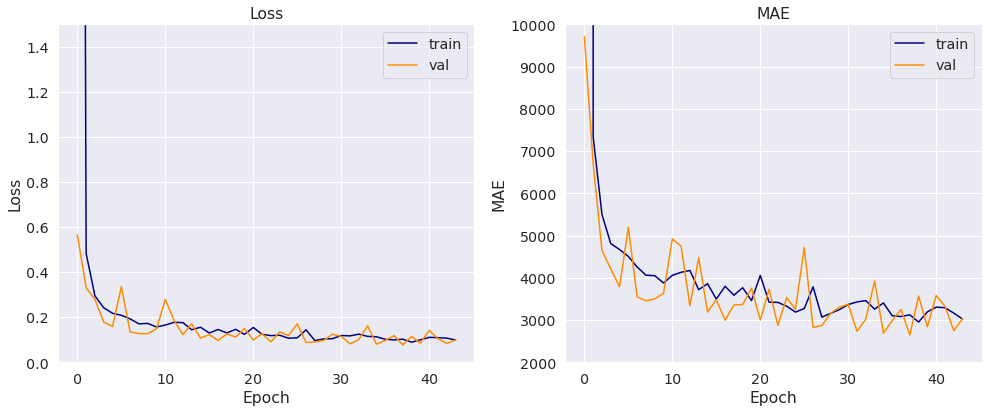

Training:
	Loss:	0.09893
	MAE:	3024.08260



Validation:
	Loss:	0.09911
	MAE:	3033.50629





KeyboardInterrupt: ignored

In [65]:
history = defaultdict(list)

for epoch_i in range(num_epochs):
    
    train_loss = train_mae = train_batches = 0    
    model2.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

        prediction = model2(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt2.step()
        opt2.zero_grad()
        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1

    history['train_loss'].append(train_loss / train_batches)
    history['train_mae'].append(train_mae / train_batches)
    

    val_loss = val_mae = val_batches = 0
    model2.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
        reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)
        prediction = model2(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

    history['val_loss'].append(val_loss / val_batches)
    history['val_mae'].append(val_mae / val_batches)

    clear_output()

    plot_learning_curves(history)

    print("Training:")
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    print("Validation:")
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

In [67]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

    prediction = model2(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.item()
    val_mae += compute_mae(reference, prediction).item()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':



	Loss:	0.08025
	MAE:	2694.84845



